# Clothes Classification Weighted Random Sampler

In [2]:
#!pip install torch
#!pip install torchvision

In [1]:
# Deep Learning
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Python Standard Lib
import re
import io
import os, glob
from collections import Counter

# AWS
import boto3

# Other
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data

### Get Datapaths from S3 Bucket

In [3]:
# s3 vars
s3 = boto3.client('s3', region_name='eu-central-1')
s3_resource = boto3.resource('s3')
bucket="bethrifty-second-hand" # change to your bucket name 

In [14]:
def load_data_paths_from_s3_bucket(prefix):
    
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    data_paths = []
    
    for page in pages:
        for l in page["Contents"]:
            data_paths.append(l["Key"])
    
    return data_paths

In [18]:
train_data_paths = load_data_paths_from_s3_bucket("clothes_dataset_upsampling/train")
valid_data_paths = load_data_paths_from_s3_bucket("clean_clothes_dataset/val")

len(train_data_paths), len(valid_data_paths)

(1667, 36)

### Get Labels

In [16]:
def get_labels_from_paths(paths, reg_ex):
    labels = set()
    for path in paths:
        match = re.search(reg_ex, path)
        if match:
            labels.add(match.group(1))
    return sorted(list(labels))

In [17]:
categories = get_labels_from_paths(train_data_paths, reg_ex=r'.*?train\/(.*)\/.*')
categories

['hemden',
 'hosen',
 'jacken',
 'polos',
 'pullover',
 'roecke',
 'schuhe',
 'shirts',
 'taschen']

#### Don't forget to do asserts

In [19]:
assert(categories == get_labels_from_paths(valid_data_paths, reg_ex=r'.*?val\/(.*)\/.*'))

### Useful Data-Conversion Dictionaries

In [21]:
cat_to_idx = {cat: idx for idx, cat in enumerate(categories)}
idx_to_cat = {idx: cat for idx, cat in enumerate(categories)}

cat_to_idx, idx_to_cat

({'hemden': 0,
  'hosen': 1,
  'jacken': 2,
  'polos': 3,
  'pullover': 4,
  'roecke': 5,
  'schuhe': 6,
  'shirts': 7,
  'taschen': 8},
 {0: 'hemden',
  1: 'hosen',
  2: 'jacken',
  3: 'polos',
  4: 'pullover',
  5: 'roecke',
  6: 'schuhe',
  7: 'shirts',
  8: 'taschen'})

### Make Data Dictionary

In [69]:
def get_data_from_paths(paths, reg_ex):
    data = dict()
    for path in paths:
        match = re.search(reg_ex, path)
        if match: 
            label = match.group(1)
            if data.get(label) != None:
                data[label].append(path)
            else:
                data[label] = [path]
    return data

In [70]:
train_data = get_data_from_paths(train_data_paths, reg_ex=r'.*?train\/(.*)\/.*')
valid_data = get_data_from_paths(valid_data_paths, reg_ex=r'.*?val\/(.*)\/.*')

len(train_data['taschen'])

15

### Convert Paths to Images

In [71]:
def path_to_data(data_paths_dict):
    data_list = []
    counter = 0
    
    for label, paths in data_paths_dict.items():
        for path in paths:
            s3_obj = s3_resource.Object(bucket, path)
            byte_image = s3_obj.get()['Body'].read()
            image = Image.open(io.BytesIO(byte_image))

            data_list.append((image, label))
        
    return data_list

In [72]:
train_data = path_to_data(train_data)
valid_data = path_to_data(valid_data)

len(train_data), len(valid_data)

(1667, 36)

hemden


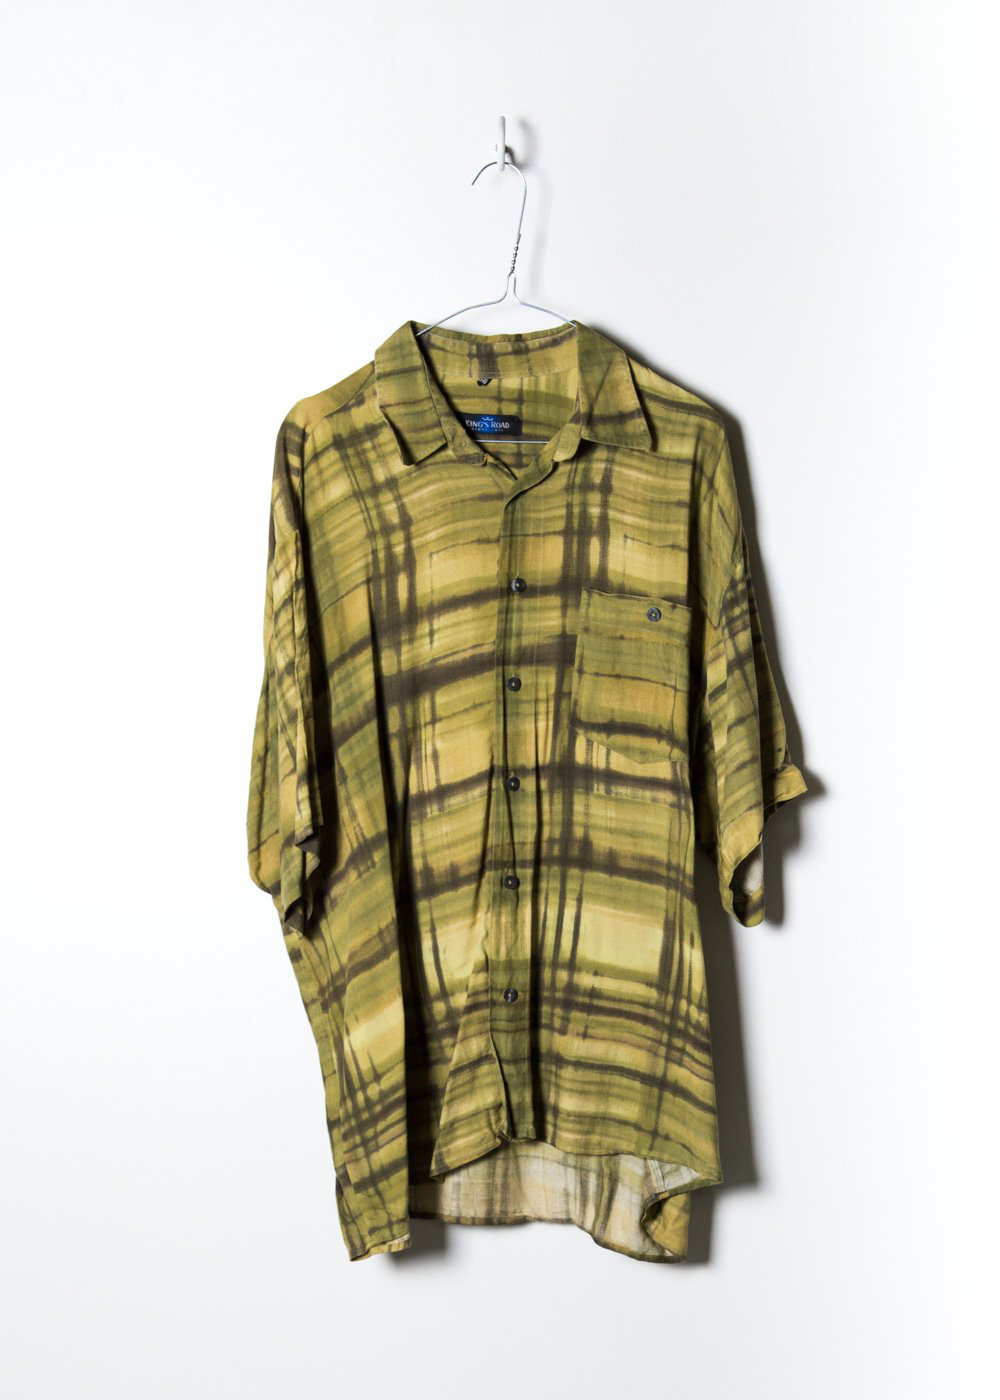

In [73]:
def print_first_images(data_list, amount=3):
    
    for img, lbl in data_list:
        print(lbl)
        display(img)
        
        amount -= 1
        if amount <= 0:
            break
            
print_first_images(train_data, amount=1)

### Data Augmentation

In [74]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [129]:
training_transforms = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomRotation((-25, 25)),
    transforms.GaussianBlur((7, 13)),
    transforms.RandomAutocontrast(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [130]:
testing_transforms = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### PyTorch Dataset Object

In [131]:
class CustomClothesData(Dataset):
    def __init__(self, data, transform):
        
        self.data = data
        self.transform = transform
        self.length = len(data)
    
    def __getitem__(self, index):
        
        X, y = self.data[index]
        
        X = self.transform(X)
        y = torch.tensor(cat_to_idx[y])
        
        return X, y
    
    def __len__(self):
        return self.length

In [132]:
training_data = CustomClothesData( 
    train_data,
    training_transforms
)

In [133]:
validation_data = CustomClothesData(
    valid_data,
    testing_transforms
)

### Class Balances

In [144]:
def get_class_distribution(dataset):
    class_balance = {}
    for tensor, label in dataset:
        if class_balance.get(idx_to_cat[label.item()]) != None:
            class_balance[idx_to_cat[label.item()]] += 1
        else:
            class_balance[idx_to_cat[label.item()]] = 1
    return class_balance

In [145]:
class_balance = get_class_distribution(training_data)
class_balance

{'hemden': 237,
 'hosen': 109,
 'jacken': 240,
 'polos': 232,
 'pullover': 240,
 'roecke': 240,
 'schuhe': 114,
 'shirts': 240,
 'taschen': 15}

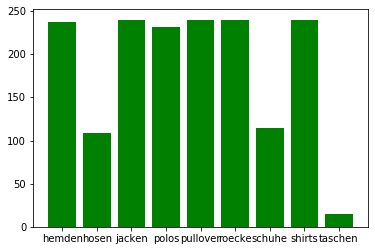

In [146]:
plt.bar(class_balance.keys(), class_balance.values(), color='g')
plt.show()

> **Caution:** Classes are imbalanced!

### PyTorch WeightedRandomSampler for Upsampling

#### Get Class Weights

In [152]:
def get_class_weights(class_dist):
    
    classes = class_dist.keys()
    class_weights = []
    total = 0
    
    for cls in classes:
        class_count = class_dist[cls]
        class_weights.append(class_count)
        total += class_count
    
    return 1/(torch.tensor(class_weights)/total)

In [154]:
class_weights = get_class_weights(class_balance)
class_weights

tensor([  7.0338,  15.2936,   6.9458,   7.1853,   6.9458,   6.9458,  14.6228,
          6.9458, 111.1333])

#### Assign every datapoint a weight

In [156]:
training_data

In [161]:
every_targets_weight = torch.tensor([class_weights[y.item()] for X, y in training_data])
every_targets_weight, every_targets_weight.shape

(tensor([  7.0338,   7.0338,   7.0338,  ..., 111.1333, 111.1333, 111.1333]),
 torch.Size([1667]))

#### Create WeightedRandomSampler

In [162]:
weighted_random_sampler = sampler.WeightedRandomSampler(every_targets_weight, len(every_targets_weight))

### PyTorch DataLoader

In [172]:
train_dataloader = DataLoader(training_data, batch_size=16, sampler=weighted_random_sampler)
valid_dataloader = DataLoader(validation_data, batch_size=16, shuffle=weighted_random_sampler)

### Show Random Image

In [173]:
tensor_to_image = transforms.ToPILImage()

def show_random_img(data_loader):
    batch_imgs, batch_labels = next(iter(data_loader))
    print(f"Feature batch shape: {batch_imgs.size()}")
    print(f"Labels batch shape: {len(batch_labels)}")
    
    img = batch_imgs[0]
    label = batch_labels[0]
    
    print(f"Label: {idx_to_cat[label.item()]}")
    return tensor_to_image(img)

Feature batch shape: torch.Size([16, 3, 400, 300])
Labels batch shape: 16
Label: hemden


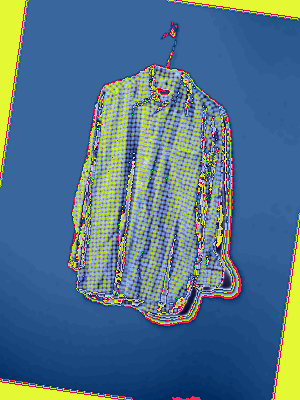

In [174]:
show_random_img(train_dataloader)

**Comment out "transform.Normalize(...)" to see the images normal**

### Look at the new class distribution

In [166]:
def class_balance(data_loader):
    
    class_balance = dict()
    for i, (images, labels) in enumerate(data_loader):
        labels = labels.tolist()
        for label in labels:
            label = idx_to_cat[label]
            if class_balance.get(label) != None:
                class_balance[label] += 1
            else:
                class_balance[label] = 1
        
    return class_balance

In [176]:
new_class_balance = class_balance(train_dataloader)
new_class_balance

{'pullover': 180,
 'schuhe': 181,
 'hemden': 164,
 'shirts': 182,
 'taschen': 173,
 'hosen': 205,
 'roecke': 187,
 'jacken': 200,
 'polos': 195}

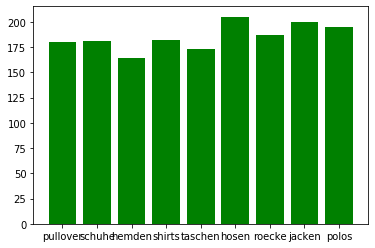

In [177]:
plt.bar(new_class_balance.keys(), new_class_balance.values(), color='g')
plt.show()

## The Convolutional Neural Network

In [178]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.resnet50(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        
        return x

In [179]:
model = CustomNeuralNetwork()
model = model.to(device)
#model

## Define a Loss function and optimizer

In [180]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training Loop

In [181]:
def accuracy(out, labels):
    return ((torch.argmax(outputs, 1) == labels).sum()) / len(labels)

In [182]:
for epoch in range(50):  # loop over the dataset multiple times
    print(f"{epoch+1}. EPOCH")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 0:
            print(f'loss: {running_loss}')
            running_loss = 0.0
            
            print(f"Accuracy = {accuracy(outputs, labels)}")
    print()
print('Finished Training')

1. EPOCH
loss: 2.326550245285034
Accuracy = 0.0625
loss: 4.548720598220825
Accuracy = 0.1875
loss: 4.578413009643555
Accuracy = 0.25
loss: 4.525045394897461
Accuracy = 0.0625
loss: 4.65278959274292
Accuracy = 0.0
loss: 4.563464403152466
Accuracy = 0.0625
loss: 4.667680978775024
Accuracy = 0.0625
loss: 4.742727756500244
Accuracy = 0.1875
loss: 4.498834133148193
Accuracy = 0.1875
loss: 4.455978870391846
Accuracy = 0.125
loss: 4.498128175735474
Accuracy = 0.1875
loss: 4.521406888961792
Accuracy = 0.1875
loss: 4.541832447052002
Accuracy = 0.1875
loss: 4.4416749477386475
Accuracy = 0.25
loss: 4.590088844299316
Accuracy = 0.125
loss: 4.498052358627319
Accuracy = 0.125
loss: 4.598999261856079
Accuracy = 0.0625
loss: 4.5104546546936035
Accuracy = 0.125
loss: 4.49680495262146
Accuracy = 0.25
loss: 4.542275667190552
Accuracy = 0.0
loss: 4.448568105697632
Accuracy = 0.125
loss: 4.423778533935547
Accuracy = 0.1875
loss: 4.374058485031128
Accuracy = 0.125
loss: 4.437232971191406
Accuracy = 0.25
los

KeyboardInterrupt: 

## Validation & Error Analysis

In [183]:
def unfold_batches(model_, data_loader):
    all_outputs = []
    all_labels = []
    wrong_images = []
    
    for i, data in enumerate(data_loader):
        model_.eval()
        # get the inputs; data is a list of [images, labels]
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model_(images)

        # collect all batches
        outputs = torch.argmax(outputs, 1).tolist()
        all_outputs += outputs
        
        labels = labels.tolist()
        all_labels  += labels
        
        wrong_classified = np.array(labels) != np.array(outputs)
        wrong_images.append((images[wrong_classified], np.array(labels)[wrong_classified], np.array(outputs)[wrong_classified]))
        
    return all_outputs, all_labels, wrong_images

In [184]:
outputs, labels, wrong_classified = unfold_batches(model, valid_dataloader)
outputs, labels

([1,
  3,
  3,
  2,
  2,
  7,
  6,
  0,
  3,
  7,
  5,
  8,
  0,
  7,
  0,
  2,
  5,
  6,
  4,
  1,
  1,
  7,
  3,
  5,
  2,
  4,
  8,
  4,
  5,
  6,
  6,
  0,
  1,
  8,
  8,
  4],
 [1,
  3,
  3,
  2,
  2,
  7,
  6,
  0,
  3,
  7,
  5,
  8,
  0,
  7,
  0,
  2,
  5,
  6,
  4,
  1,
  1,
  7,
  3,
  5,
  2,
  4,
  8,
  4,
  5,
  6,
  6,
  0,
  1,
  8,
  8,
  4])

In [185]:
# accuracy
(np.array(outputs) == np.array(labels)).sum() / len(outputs)

1.0

In [186]:
# confusion matrix

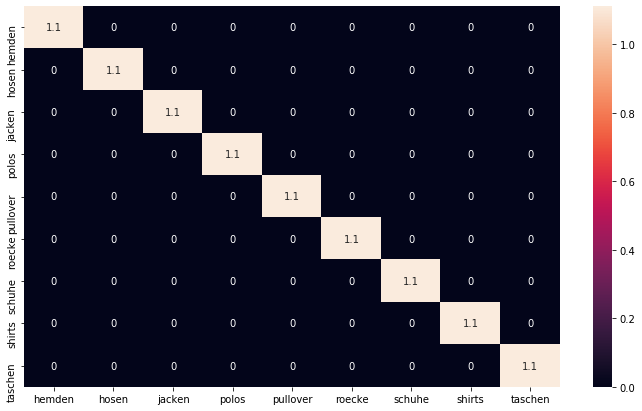

In [187]:
# BUILD CONFUSION MATRIX
# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
conf_matrix = confusion_matrix(labels, outputs)
df_cm = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [i for i in categories], columns = [i for i in categories])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [188]:
inverse_transforms = transforms.Compose([
    transforms.Normalize(mean = 1/mean, std = 1/std),
    transforms.ToPILImage()
])

In [189]:
def show_wrong_classified():
    for batch in wrong_classified:
        for idx, image in enumerate(batch[0]):
            print(f"Actual   : {idx_to_cat[batch[1][idx]]}")
            print(f"Predicted: {idx_to_cat[batch[2][idx]]}")
            display(inverse_transforms(image))
            print()
            
show_wrong_classified()